# Annotated Corpus for Named Entity Recognition

The processed dataset *NER* in this notebook, is available on *Kaggle*.[link](https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus?select=ner.csv)



## 1. Import the Libraries 

In [101]:
import pandas as pd

import re
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import swifter
import tensorflow as tf
from ast import literal_eval
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, RNN, GRUCell, Conv2D, Embedding, Bidirectional, Dropout
import matplotlib.pyplot as plt

## 2. Upload and explore the Data

In [102]:
df = pd.read_csv(r"E:\Jihane 2022\Exams\exam 157\ner_dataset.csv",encoding= 'unicode_escape')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


**Examination of each column :**
- Sentence # : Contains sentence number in the text.
- Word : Lists the words in each sentence.
- POS : Refers to the gramatical group each word belongs to.
- Tag : Identifies the word's name entity 

In [103]:
sentence = df["Sentence #"].value_counts().index[-1]
nbr_sentence = sentence.split()
print("The text contains",nbr_sentence[-1], "sentences")
print("There is",df.isnull().sum().sum(), "missing values")

The text contains 47959 sentences
There is 1000616 missing values


In [104]:
tags = set(df.Tag)
tags

{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}

**B** denotes the **B**eginning of an entity, **I** stands for "inside" and is used for all words comprising the entity except the first one, and **O** means the absence of entity.
The acronyms refers to : 
une liste:
- geo : Administrative geographic area
- per : Person
- org : Organization
- gpe : Geopolitical entity
- tim : Time
- art : Work of art
- eve : Name of events
- nat : Natural hazards


## 2. Definition of required functions 


In [105]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)

    # remove stopword
    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()


In [106]:
# Sentence construction function
def liste_phrase(liste):
    phrase = ' '.join(liste)
    return phrase

In [75]:
#def target_tokenize(dict_idx, liste_liste):
#    target_prep = []
#    for liste in liste_liste:
#        t_tokenized = []
#        for tag in liste:
#            t_tokenized.append(dict_idx[tag])
#        target_prep.append(t_tokenized)
#    return target_prep
    

In [107]:
# Tokenization function
def target_tokenize(target, tag2indx):
    target_prep = []
    for t in target :
        target_tokenized = []
        for tag in t :
            target_tokenized.append(tag2indx[tag])
        target_prep.append(target_tokenized)
    return target_prep

## 3. Data pre-processing
### 3.1. Missing values

In [108]:
# Remove missing values :
df = df.fillna(method='ffill')


In [109]:
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [110]:
df.shape

(1048575, 4)

### 3.2. Stop-words

In [112]:
# language choice
stop_words = stopwords.words('english')

df.Word = df.Word.swifter.apply(lambda x :preprocess_sentence(x))
df.head()

Pandas Apply:   0%|          | 0/1048575 [00:00<?, ?it/s]

,Sentence #,Word,POS,Tag
0,Sentence: 1,thousands,NNS,O
1,Sentence: 1,,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,,VBP,O
4,Sentence: 1,marched,VBN,O


**NB** : The words removed, were replaced with ' ' (space). so the next step is to delete those rows from the dataframe.

In [113]:
df = df[df["Word"] != '']

In [114]:
df.shape

(631229, 4)

**NB** : This step cuts down 40% of the dataframe.

### 3.3. Sentence construction: Putting words together

In [115]:
df = df.drop(['POS'], axis = 1)
df = df.groupby('Sentence #').agg(list)
df = df.reset_index(drop = True)
df.head()

,Word,Tag
0,"[thousands, demonstrators, marched, london, pr...","[O, O, O, B-geo, O, O, B-geo, O, O, B-gpe, O, ..."
1,"[iranian, officials, say, expect, get, access,...","[B-gpe, O, O, O, O, O, O, O, O, O, B-tim, B-or..."
2,"[helicopter, gunships, saturday, pounded, mili...","[O, O, B-tim, O, O, O, B-geo, O, O, O, B-org, ..."
3,"[left, tense, hour long, standoff, riot, polic...","[O, O, O, O, O, O, O]"
4,"[. ., relief, coordinator, jan, egeland, said,...","[B-geo, O, O, B-per, I-per, O, B-tim, B-geo, B..."


In [116]:
df.shape

(47958, 2)

In [117]:
# Transformation of the list of words to a sentence :
sentences = []
for i in df.Word.to_list():
    sentences.append(liste_phrase(i))
    
df["Phrases"] = sentences

df = df.drop(["Word"], axis = 1)
df.head()

,Tag,Phrases
0,"[O, O, O, B-geo, O, O, B-geo, O, O, B-gpe, O, ...",thousands demonstrators marched london protest...
1,"[B-gpe, O, O, O, O, O, O, O, O, O, B-tim, B-or...",iranian officials say expect get access sealed...
2,"[O, O, B-tim, O, O, O, B-geo, O, O, O, B-org, ...",helicopter gunships saturday pounded militant ...
3,"[O, O, O, O, O, O, O]",left tense hour long standoff riot police .
4,"[B-geo, O, O, B-per, I-per, O, B-tim, B-geo, B...",. . relief coordinator jan egeland said sunday...


In [118]:
# transformation of the type of the colunm df[Tags]

Tags = []
for i in df.Tag.to_list():
    Tags.append(str(i))
    
df["Tags"] = Tags
df = df.drop(["Tag"], axis = 1)
df.head()

,Phrases,Tags
0,thousands demonstrators marched london protest...,"['O', 'O', 'O', 'B-geo', 'O', 'O', 'B-geo', 'O..."
1,iranian officials say expect get access sealed...,"['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '..."
2,helicopter gunships saturday pounded militant ...,"['O', 'O', 'B-tim', 'O', 'O', 'O', 'B-geo', 'O..."
3,left tense hour long standoff riot police .,"['O', 'O', 'O', 'O', 'O', 'O', 'O']"
4,. . relief coordinator jan egeland said sunday...,"['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-..."


### 3.4. Tokenization

In [119]:
maxlen = []
for i in range(len(df.Phrases)):
    maxlen.append(len(df.Phrases[i].split()))
    
print(f"The longest sentence contains {max(maxlen)} words.")
print(f"The shortest sentence contains {min(maxlen)} word.")


The longest sentence contains 47 words.
The shortest sentence contains 1 word.


In [120]:
feature = df.Phrases
target = df.Tags

In [121]:
tokenizer_ft = tf.keras.preprocessing.text.Tokenizer(num_words = 24000)
tokenizer_ft.fit_on_texts(feature)

In [122]:
word2idx = tokenizer_ft.word_index
word2idx

{'said': 1,
 'says': 2,
 'say': 3,
 'president': 4,
 'officials': 5,
 'government': 6,
 'two': 7,
 'killed': 8,
 'people': 9,
 'also': 10,
 'year': 11,
 'new': 12,
 'united': 13,
 'military': 14,
 'last': 15,
 'country': 16,
 'minister': 17,
 'police': 18,
 'one': 19,
 'iraq': 20,
 'security': 21,
 'states': 22,
 'least': 23,
 'state': 24,
 'three': 25,
 'tuesday': 26,
 'week': 27,
 'since': 28,
 'world': 29,
 'forces': 30,
 'thursday': 31,
 'group': 32,
 'iran': 33,
 'friday': 34,
 'monday': 35,
 'wednesday': 36,
 'sunday': 37,
 'troops': 38,
 'oil': 39,
 'authorities': 40,
 'would': 41,
 'iraqi': 42,
 'saturday': 43,
 'first': 44,
 'month': 45,
 'prime': 46,
 'foreign': 47,
 'city': 48,
 'nuclear': 49,
 'international': 50,
 'attacks': 51,
 'militants': 52,
 'palestinian': 53,
 'israeli': 54,
 'afghanistan': 55,
 'nations': 56,
 'china': 57,
 'south': 58,
 'called': 59,
 'years': 60,
 'former': 61,
 'talks': 62,
 'attack': 63,
 'war': 64,
 'bush': 65,
 'israel': 66,
 'province': 67,


In [123]:
idx2word = tokenizer_ft.index_word
idx2word

{1: 'said',
 2: 'says',
 3: 'say',
 4: 'president',
 5: 'officials',
 6: 'government',
 7: 'two',
 8: 'killed',
 9: 'people',
 10: 'also',
 11: 'year',
 12: 'new',
 13: 'united',
 14: 'military',
 15: 'last',
 16: 'country',
 17: 'minister',
 18: 'police',
 19: 'one',
 20: 'iraq',
 21: 'security',
 22: 'states',
 23: 'least',
 24: 'state',
 25: 'three',
 26: 'tuesday',
 27: 'week',
 28: 'since',
 29: 'world',
 30: 'forces',
 31: 'thursday',
 32: 'group',
 33: 'iran',
 34: 'friday',
 35: 'monday',
 36: 'wednesday',
 37: 'sunday',
 38: 'troops',
 39: 'oil',
 40: 'authorities',
 41: 'would',
 42: 'iraqi',
 43: 'saturday',
 44: 'first',
 45: 'month',
 46: 'prime',
 47: 'foreign',
 48: 'city',
 49: 'nuclear',
 50: 'international',
 51: 'attacks',
 52: 'militants',
 53: 'palestinian',
 54: 'israeli',
 55: 'afghanistan',
 56: 'nations',
 57: 'china',
 58: 'south',
 59: 'called',
 60: 'years',
 61: 'former',
 62: 'talks',
 63: 'attack',
 64: 'war',
 65: 'bush',
 66: 'israel',
 67: 'province',


In [124]:
vocab_size = tokenizer_ft.num_words
vocab_size

24000

In [125]:
feature_prep = tokenizer_ft.texts_to_sequences(feature)

In [126]:
feature[1]

'iranian officials say expect get access sealed sensitive parts plant wednesday iaea surveillance system begins functioning .'

In [127]:
feature_prep[1]

[232,
 5,
 3,
 1623,
 648,
 878,
 4001,
 2976,
 652,
 1021,
 36,
 1498,
 2030,
 372,
 2031,
 5622]

In [96]:
feature_padded = tf.keras.preprocessing.sequence.pad_sequences(feature_prep, maxlen = max(maxlen), padding = 'post', truncating = 'post')
feature_padded[1]

array([ 232,    5,    3, 1623,  648,  878, 4001, 2976,  652, 1021,   36,
       1498, 2030,  372, 2031, 5622,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [99]:
tags = df.Tags.unique()
tag2indx = {}
for i, tag in enumerate(tags):
    i+=1
    tag2indx[tag]=i
    
tag2indx
    

{"['O', 'O', 'O', 'B-geo', 'O', 'O', 'B-geo', 'O', 'O', 'B-gpe', 'O', 'O', 'O']": 1,
 "['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'B-org', 'O', 'O', 'O', 'O', 'O']": 2,
 "['O', 'O', 'B-tim', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O']": 3,
 "['O', 'O', 'O', 'O', 'O', 'O', 'O']": 4,
 "['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-tim', 'B-geo', 'B-gpe', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O']": 5,
 "['B-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'B-per', 'B-gpe', 'B-geo', 'B-geo', 'O']": 6,
 "['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'B-geo', 'O']": 7,
 "['O', 'O', 'O', 'O']": 8,
 "['O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']": 9,
 "['B-gpe', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']": 10,
 "['B-geo', 'O', 'O', 'O', 'O', 'B-org', 'I-or

In [100]:
tag2indx['I-nat']

KeyError: 'I-nat'

In [475]:
indx2tag = {v: k for k, v in tag2indx.items()}
indx2tag

{1: 'O',
 2: 'B-geo',
 3: 'B-gpe',
 4: 'B-per',
 5: 'I-geo',
 6: 'B-org',
 7: 'I-org',
 8: 'B-tim',
 9: 'B-art',
 10: 'I-art',
 11: 'I-per',
 12: 'I-gpe',
 13: 'I-tim',
 14: 'B-nat',
 15: 'B-eve',
 16: 'I-eve',
 17: 'I-nat'}

In [476]:
num_tags = len(tags)
num_tags

17

In [477]:
target[1]

"['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'B-org', 'O', 'O', 'O', 'O', 'O']"

In [479]:

target_ready = []

for sen_tags in target:
    target_ready.append(literal_eval(sen_tags))
    
target_ready[1][0]

'B-gpe'

In [481]:
target_prep = target_tokenize(target_ready, tag2indx)
target_prep[1][0]

3

In [482]:
def maxlen(liste):
    maxlen = []
    for l in liste:
        maxlen.append(len(l))
    return max(maxlen)

maxlen_target = maxlen(target_prep)
maxlen_target

33

In [483]:
target_padded = tf.keras.preprocessing.sequence.pad_sequences(target_prep, maxlen = maxlen_target, padding = 'post', truncating = 'post')
target_padded[1]

array([3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 6, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [484]:
# Séparation du JDD en jeux d'entrainement et jeu de test : 


X_train, X_test, y_train, y_test = train_test_split(feature_padded, target_padded, test_size = 0.2, random_state = 1234)

In [500]:


model = Sequential()
model.add(Embedding(10000, 10000))
model.add(Bidirectional(RNN(GRUCell(256, recurrent_initializer='glorot_uniform'),
                                return_sequences=True)))
model.add(Dropout(0.3))
model.add(Dense(18, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 10000)       100000000 
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 512)        15756288  
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, None, 512)         0         
                                                                 
 dense_6 (Dense)             (None, None, 18)          9234      
                                                                 
Total params: 115,765,522
Trainable params: 115,765,522
Non-trainable params: 0
_________________________________________________________________


In [501]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [502]:
history = model.fit(X_train, y_train, batch_size = 64, epochs = 5, validation_data = [X_test, y_test])

Epoch 1/5
57/57 [==============================] - 211s 4s/step - loss: 0.5018 - accuracy: 0.8785 - val_loss: 0.2704 - val_accuracy: 0.9262
Epoch 2/5
57/57 [==============================] - 203s 4s/step - loss: 0.2215 - accuracy: 0.9351 - val_loss: 0.2418 - val_accuracy: 0.9307
Epoch 3/5
57/57 [==============================] - 200s 4s/step - loss: 0.1627 - accuracy: 0.9488 - val_loss: 0.2459 - val_accuracy: 0.9309
Epoch 4/5
57/57 [==============================] - 203s 4s/step - loss: 0.1273 - accuracy: 0.9573 - val_loss: 0.2670 - val_accuracy: 0.9267
Epoch 5/5
57/57 [==============================] - 208s 4s/step - loss: 0.0992 - accuracy: 0.9657 - val_loss: 0.2882 - val_accuracy: 0.9272


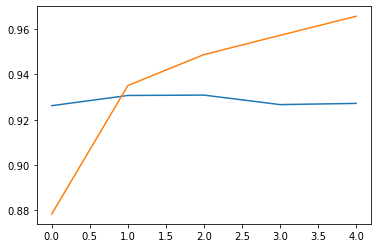

In [508]:


plt.plot(history.history["val_accuracy"])
plt.plot(history.history["accuracy"]);

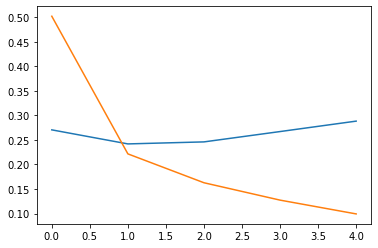

In [509]:
import matplotlib.pyplot as plt

plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"]);

In [516]:
y_prob = model.predict(X_test[:2])
y_pred = y_prob.argmax(axis=2)
y_pred

array([[ 1,  1,  8,  3,  1,  1,  1,  1,  6, 11,  1,  1,  6,  7,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0]], dtype=int64)

In [514]:
y_test[:2]

array([[1, 1, 8, 3, 1, 1, 1, 1, 6, 7, 1, 1, 6, 7, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [513]:
test = model.evaluate(X_test, y_test, batch_size = 128)
print("test loss and test accuracy" , test)

8/8 [==============================] - 8s 970ms/step - loss: 0.2882 - accuracy: 0.9272
test loss and test accuracy [0.2882330119609833, 0.9272260665893555]
